<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


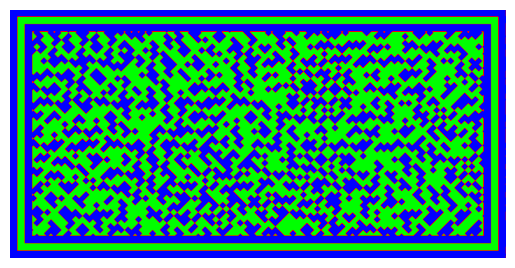

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
###     YOUR CODE FOR TASK 1    ###
### ADD MORE CELLS IF NECESSARY ###

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yb = torch.argmax(yb, dim=1)  # Convert target tensor to 1-dimensional tensor

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())  # Use long() to convert targets to class indices

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data.long())  # Use long() for target comparison

    return loss.item(), corrects, len(xb)


In [9]:
from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):


        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:

            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)

            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num


        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:

                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)

                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num


        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

In [10]:
from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [11]:
bs=64
train_dl, valid_dl = get_data(train_dataset, val_dataset, bs)

In [12]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [34]:
# model = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.AvgPool2d(4),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(60, 10),
# )
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 10, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(3600, 10),
)
# model = nn.Sequential(
#     nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(64),
#     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(128),
#     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(256),
#     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.BatchNorm2d(512),
#     nn.AdaptiveAvgPool2d(1),
#     Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Linear(512, 10)
# )


In [36]:
from torch import optim

lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  5%|▌         | 1/20 [01:38<31:07, 98.30s/it]

EPOCH: 01/20 LOSS: 0.7571 ACC: 0.6685  VAL-LOSS: 1.0597 VAL-ACC: 0.5260 


 10%|█         | 2/20 [03:15<29:22, 97.94s/it]

EPOCH: 02/20 LOSS: 0.7306 ACC: 0.6763  VAL-LOSS: 1.0250 VAL-ACC: 0.5345 


 15%|█▌        | 3/20 [04:54<27:48, 98.16s/it]

EPOCH: 03/20 LOSS: 0.6885 ACC: 0.7020  VAL-LOSS: 1.0090 VAL-ACC: 0.5525 


 20%|██        | 4/20 [06:31<26:01, 97.61s/it]

EPOCH: 04/20 LOSS: 0.6495 ACC: 0.7188  VAL-LOSS: 1.0682 VAL-ACC: 0.5695 


 25%|██▌       | 5/20 [08:06<24:13, 96.88s/it]

EPOCH: 05/20 LOSS: 0.6036 ACC: 0.7447  VAL-LOSS: 1.0154 VAL-ACC: 0.5655 


 30%|███       | 6/20 [09:42<22:29, 96.40s/it]

EPOCH: 06/20 LOSS: 0.5698 ACC: 0.7593  VAL-LOSS: 1.1959 VAL-ACC: 0.5305 


 35%|███▌      | 7/20 [11:17<20:50, 96.16s/it]

EPOCH: 07/20 LOSS: 0.5540 ACC: 0.7611  VAL-LOSS: 1.0920 VAL-ACC: 0.5660 


 40%|████      | 8/20 [12:53<19:11, 95.92s/it]

EPOCH: 08/20 LOSS: 0.5177 ACC: 0.7859  VAL-LOSS: 1.1132 VAL-ACC: 0.5545 


 45%|████▌     | 9/20 [14:28<17:32, 95.72s/it]

EPOCH: 09/20 LOSS: 0.4894 ACC: 0.7969  VAL-LOSS: 1.0574 VAL-ACC: 0.5895 


 50%|█████     | 10/20 [16:04<15:58, 95.84s/it]

EPOCH: 10/20 LOSS: 0.4451 ACC: 0.8147  VAL-LOSS: 1.2356 VAL-ACC: 0.5720 


 55%|█████▌    | 11/20 [17:39<14:19, 95.54s/it]

EPOCH: 11/20 LOSS: 0.4206 ACC: 0.8268  VAL-LOSS: 1.0536 VAL-ACC: 0.5820 


 60%|██████    | 12/20 [19:14<12:42, 95.28s/it]

EPOCH: 12/20 LOSS: 0.3853 ACC: 0.8460  VAL-LOSS: 1.2072 VAL-ACC: 0.5650 


 65%|██████▌   | 13/20 [20:48<11:05, 95.12s/it]

EPOCH: 13/20 LOSS: 0.3353 ACC: 0.8653  VAL-LOSS: 1.2337 VAL-ACC: 0.5790 


 70%|███████   | 14/20 [22:24<09:31, 95.28s/it]

EPOCH: 14/20 LOSS: 0.2825 ACC: 0.8895  VAL-LOSS: 1.5608 VAL-ACC: 0.5685 


 75%|███████▌  | 15/20 [23:59<07:55, 95.15s/it]

EPOCH: 15/20 LOSS: 0.2591 ACC: 0.9000  VAL-LOSS: 1.5431 VAL-ACC: 0.5860 


 80%|████████  | 16/20 [25:34<06:20, 95.03s/it]

EPOCH: 16/20 LOSS: 0.2526 ACC: 0.8997  VAL-LOSS: 1.5247 VAL-ACC: 0.5990 


 85%|████████▌ | 17/20 [27:09<04:44, 94.95s/it]

EPOCH: 17/20 LOSS: 0.2226 ACC: 0.9140  VAL-LOSS: 1.5663 VAL-ACC: 0.5955 


 90%|█████████ | 18/20 [28:43<03:09, 94.96s/it]

EPOCH: 18/20 LOSS: 0.1892 ACC: 0.9281  VAL-LOSS: 1.6739 VAL-ACC: 0.5930 


 95%|█████████▌| 19/20 [30:19<01:35, 95.09s/it]

EPOCH: 19/20 LOSS: 0.2016 ACC: 0.9239  VAL-LOSS: 1.7197 VAL-ACC: 0.5805 


100%|██████████| 20/20 [31:54<00:00, 95.74s/it]

EPOCH: 20/20 LOSS: 0.1490 ACC: 0.9444  VAL-LOSS: 1.7259 VAL-ACC: 0.5940 


## Task 1: Question 5d

# Task 2: Carpet Matching 

In [37]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [16]:
# # function to determine performance of model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#
#         q = queries[i][None].float().cuda()
#         t = targets[i].float().cuda()
#
#         with torch.no_grad():
#
#
#             ### MODIFY IF NECESSARY ###
#             emb_q = net(q).cpu().numpy()
#             emb_t = net(t).cpu().numpy()
#
#             dists = cdist(emb_q, emb_t)
#
#             if top == 1:
#                 pred = np.argmin(dists)
#
#                 if pred == gt[i]:
#                     cnt += 1
#
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0,:top].tolist():
#                     cnt+=1
#     return (100*cnt/gt.shape[0])

In [17]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [38]:
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn

# Define your model for task 2
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Create an instance of the model
net = Model()

# Load the pre-trained weights (if available)
# net.load_state_dict(torch.load('task2_model_weights.pth'))

# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries[i][None]).float().to(device)
        t = torch.from_numpy(targets[i]).float().to(device)

        with torch.no_grad():
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

In [39]:
print(top_1_accuracy)
print(top_3_accuracy)

19.0
63.666666666666664


In [46]:
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import cdist

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(164864, num_classes)  # Adjust the input size based on your data

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Function to determine performance of the model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = queries[i][None].float().to(device)
        t = targets[i].float().to(device)

        with torch.no_grad():
            emb_q = net(q)
            emb_t = net(t)

            dists = cdist(emb_q.cpu().numpy(), emb_t.cpu().numpy())

            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Loading training and testing data for Task 2
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(int)
gt = task2['arr_2'].astype(int)  # Ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

# Determine the number of distinct classes in your dataset
num_classes = len(np.unique(y))

# Convert numpy arrays to PyTorch tensors
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).long().to(device)
gt = torch.from_numpy(gt).long().to(device)
queries = torch.from_numpy(queries).float().to(device)
targets = torch.from_numpy(targets).float().to(device)

# Create an instance of the model
net = Model().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 32
total_samples = X.shape[0]
num_batches = total_samples // batch_size

for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        inputs = X[start_idx:end_idx]
        labels = y[start_idx:end_idx]

        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

print(f"Top-1 Accuracy: {top_1_accuracy}%")
print(f"Top-3 Accuracy: {top_3_accuracy}%")


Epoch [1/10], Loss: 5.298084735870361
Epoch [2/10], Loss: 5.254850387573242
Epoch [3/10], Loss: 1.2600812911987305
Epoch [4/10], Loss: 0.009972329251468182


KeyboardInterrupt: 